# Homework 7
Qingyuan Chen 

In [2]:
#IMPORT ALL NECESSARY PACKAGES AT THE TOP OF THE CODE
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt

# Custom display helpers
from IPython.display import Markdown

def md_print(md_str: str):
    display(Markdown(md_str))

def lax_eq(equation):
    return sym.latex(equation , mode='inline')



import sympy as sym
def get_eu_la(L: sym.Function, q: sym.Matrix, t: sym.symbols):
    """Generate euler lagrangian using sympy jacobian

    Args:
        L (sym.Function): Lagrangian equation
        q (sym.Matrix): matrix of system-var q
        t (sym.symbols): time symbol (needed for q.diff(t))
    """

    q_dot = q.diff(t)
    dL_dq = sym.simplify(sym.Matrix([L]).jacobian(q).T)
    dL_dq_dot = sym.simplify(sym.Matrix([L]).jacobian(q_dot).T)

    return sym.simplify(dL_dq_dot.diff(t) - dL_dq)


def solve_and_print(variables: sym.Matrix,
                    eu_la_eq: sym.Eq , quiet = False) -> list[dict[any]]:
    """Solve the given eu_la equation  

    Args:
        variables (sym.Matrix): var to solve for
        eu_la_eq (sym.Eq): eu_la equation
        quiet (bool): turn off any printing if True

    Returns:
        list[dict[sym.Function]]: list of solution dicts (keyed with variables)
    """
    solution_dicts = sym.solve(eu_la_eq, variables, dict=True)
    i = 0
    print(f"Total of {len(solution_dicts)} solutions")
    for solution_dict in solution_dicts:
        i += 1
        if not quiet: md_print(f"solution : {i} / {len(solution_dicts)}")
        for var in variables:
            sol = solution_dict[var]
            if not quiet: md_print(f"{lax_eq(var)} = {lax_eq(sol.expand())}")
    return solution_dicts

def lambdify_sys(var_list: list, function_dict: dict[any, sym.Function], keys =None):
    lambda_dict ={}
    if keys is None:
        keys = function_dict.keys()
    for var in keys:
        acceleration_function = (function_dict[var])
        lambda_func = sym.lambdify(var_list, acceleration_function )
        lambda_dict[var] = lambda_func
    return lambda_dict

def make_system_equation(lambda_dict,lam_keys):
    '''
    '''
    # def system_equation(state , lambda_dict ,lam_keys , optional_args = None ):
    def system_equation(state , optional_args = None ):
        state = state.tolist()
        accel_list = []
        # print(optional_args)
        # print(lambda_input)
        for key in lam_keys:
            if optional_args is not None:
                accel_list.append(lambda_dict[key](*state , optional_args) )
            else:
                accel_list.append(lambda_dict[key](*state) )

        
        velocity_list = state[int (len(state)/2): :]
        out_list = velocity_list + accel_list
        return np.array(out_list) 
    # return lambda state , optional_args = None: system_equation(state , lambda_dict , lam_keys , optional_args)
    return system_equation


## Problem 1
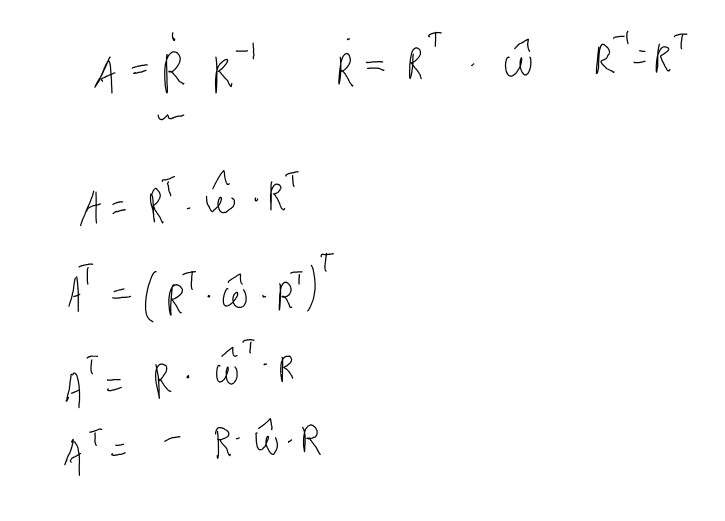

## Problem 2

In [19]:


def hat(w,use_sym=True):
    if use_sym:
        what = sym.Matrix([[    0,-w[2], w[1]],
                           [ w[2],    0,-w[0]],
                           [-w[1], w[0],   0]])
    else:
        what = np.array([[    0,-w[2], w[1]],
                         [ w[2],    0,-w[0]],
                         [-w[1], w[0],   0]])
    return what

def unhat(what,use_sym=True):
    if use_sym:
        w = sym.Matrix([what[2,1],what[0,2],what[1,0]])
    else:
        w = np.array([what[2,1],what[0,2],what[1,0]])
    return w

w1 , w2,w3 = sym.symbols(r'\omega_1 ,\omega_2,\omega_3')
r1,r2,r3 = sym.symbols(r'r_1 ,r_2,r_3')

w = sym.Matrix([
    w1,
    w2,
    w3
])

r = sym.Matrix([
    r1,
    r2,
    r3
])

w_hat = hat(w)
r_hat = hat(r)
display(w_hat)
display(r_hat)

lhs = w_hat @ r
rhs = r_hat @ w

md_print("**Problem 2 solution**")
md_print(f"Left hand side: $\hat\omega r_b$ =")
display(lhs)
md_print(f"Right hand side: $\hat r \omega_b$ =")
display(rhs)

md_print(f"lhs == rhs : {lhs == -rhs}")


Matrix([
[        0, -\omega_3,  \omega_2],
[ \omega_3,         0, -\omega_1],
[-\omega_2,  \omega_1,         0]])

Matrix([
[   0, -r_3,  r_2],
[ r_3,    0, -r_1],
[-r_2,  r_1,    0]])

**Problem 2 solution**

Left hand side: $\hat\omega r_b$ =

Matrix([
[ \omega_2*r_3 - \omega_3*r_2],
[-\omega_1*r_3 + \omega_3*r_1],
[ \omega_1*r_2 - \omega_2*r_1]])

Right hand side: $\hat r \omega_b$ =

Matrix([
[-\omega_2*r_3 + \omega_3*r_2],
[ \omega_1*r_3 - \omega_3*r_1],
[-\omega_1*r_2 + \omega_2*r_1]])

lhs == rhs : True

## Problem 3

In [2]:
# Transformation helpers 

def rotz(theta):
    return sym.Matrix([[sym.cos(theta) , -sym.sin(theta) ,0 ,0 ],
                        [sym.sin(theta) , sym.cos(theta) ,0 ,0 ],
                        [ 0            , 0               ,1 ,0 ],
                        [0             ,0                ,0 ,1 ]])

def trans(x=0,y=0,z=0):
    return sym.Matrix([
        [1,0,0,x],
        [0,1,0,y],
        [0,0,1,0],
        [0,0,0,1]
])

def get_x_y(T):
    return T[0,3] , T[1,3]

# The same as Unhat but omega then v 
# se3 is T-1 @ T_dot
def se3ToVec(se3mat):
    """ Converts an se3 matrix into a spatial velocity vector

    :param se3mat: A 4x4 matrix in se3
    :return: The spatial velocity 6-vector corresponding to se3mat

    Example Input:
        se3mat = np.array([[ 0, -3,  2, 4],
                           [ 3,  0, -1, 5],
                           [-2,  1,  0, 6],
                           [ 0,  0,  0, 0]])
    Output:
        np.array([1, 2, 3, 4, 5, 6])
    """
    return sym.Matrix([se3mat[2,1] , se3mat[0,2] ,se3mat[1,0] ,
    se3mat[0,3], se3mat[1,3], se3mat[2,3]
    ])

def TransToRp(T):
    """Converts a homogeneous transformation matrix into a rotation matrix
    and position vector

    :param T: A homogeneous transformation matrix
    :return R: The corresponding rotation matrix,
    :return p: The corresponding position vector.

    Example Input:
        T = np.array([[1, 0,  0, 0],
                      [0, 0, -1, 0],
                      [0, 1,  0, 3],
                      [0, 0,  0, 1]])
    Output:
        (np.array([[1, 0,  0],
                   [0, 0, -1],
                   [0, 1,  0]]),
         np.array([0, 0, 3]))
    """
    return T[0: 3, 0: 3], T[0: 3, 3]

def TransInv(T):
    """Inverts a homogeneous transformation matrix

    :param T: A homogeneous transformation matrix
    :return: The inverse of T
    Uses the structure of transformation matrices to avoid taking a matrix
    inverse, for efficiency.

    Example input:
        T = np.array([[1, 0,  0, 0],
                      [0, 0, -1, 0],
                      [0, 1,  0, 3],
                      [0, 0,  0, 1]])
    Output:
        np.array([[1,  0, 0,  0],
                  [0,  0, 1, -3],
                  [0, -1, 0,  0],
                  [0,  0, 0,  1]])
    """
    R, p = TransToRp(T)
    Rt = R.T

    return sym.Matrix([
        [Rt , - Rt @ p],
        [sym.zeros(1,3) ,sym.ones(1)] 
    ])


In [3]:
# Use the same frame in given picture,
# W is world frame, on the ground, in middle
# A is the joint between 2 legs, same orientation as world
# B is right leg CG, C is left leg CG
# D is right leg tip, E is left leg tip

# Parameter definition

L =1 # Leg length
W = 0.2 # Leg Width
mass =1 # Leg mass
J_inertia = 1 # Leg inertia
g = 9.8 # gravity in y direction
k_gain = 20
# State variables
t= sym.symbols('t')
x = sym.Function(r'x')(t)
y = sym.Function(r'y')(t)
theta1 = sym.Function(r'\theta_1')(t)
theta2 = sym.Function(r'\theta_2')(t)

q = sym.Matrix([x,y,theta1,theta2])
q_dot = q.diff(t)
q_ddot = q_dot.diff(t)
# Define the transforms
Twa = trans(x,y)
Tab = rotz(theta1) @ trans(y=-L/2)
Tac = rotz(theta2) @ trans(y=-L/2)
Tbd = trans(y=-L/2)
Tce = trans(y=-L/2)

Twb = Twa @ Tab
Twc = Twa @ Tac
Twd = Twb @ Tbd
Twe = Twc @ Tce

V_b = se3ToVec(TransInv(Twb) @ (Twb).diff(t))
V_c = se3ToVec(TransInv(Twc) @ (Twc).diff(t))


mass_matrix = sym.Matrix([
        [mass,0,0],
        [0,mass,0],
        [0,0,mass],
])

inertia_matrix = sym.Matrix([
        [0,0,0],
        [0,0,0],
        [0,0,J_inertia],
])

# display(sym.zeros(3,3))
inertia_mass_6 = sym.Matrix([
    [inertia_matrix , sym.zeros(3,3)],
    [sym.zeros(3,3) , mass_matrix]
])

# Need to take KE out of matrix form.
KE_b =( 1/2 * ((V_b).T @ inertia_mass_6 @ V_b ))[0]
PE_b = get_x_y(Twb)[1] * mass * g
KE_c =( 1/2 * ((V_c).T @ inertia_mass_6 @ V_c ))[0]
PE_c = get_x_y(Twc)[1] * mass * g

eu_la = get_eu_la(((KE_b + KE_c) - (PE_b + PE_c)).simplify(), q, t)
# display(eu_la)

theta1_desire = sym.pi / 15 + sym.pi/3 * (sym.sin(t/2) **2 )
theta2_desire = - sym.pi / 15 - sym.pi/3 * (sym.sin(t/2) **2 )

force_q = sym.Matrix([
        0,
        0,
        -20 * (theta1 - theta1_desire) ,
        -20 * (theta2 - theta2_desire) ,
])

# Define constrain and lambdas
# 1 for right foot, frame D
lambda_scaler1 = sym.symbols('\lambda_1')
constrain_phi1 = get_x_y(Twd)[1] 

# 2 for left foot, frame E
lambda_scaler2 = sym.symbols('\lambda_2')
constrain_phi2 = get_x_y(Twe)[1] 
constrain_sum = lambda_scaler1*constrain_phi1 + lambda_scaler2*constrain_phi2
constrain_diff_q = sym.Matrix([constrain_sum]).jacobian(q).T

lhs = sym.Matrix([
        eu_la,
        constrain_phi1.diff(t).diff(t),
        constrain_phi2.diff(t).diff(t),
])
rhs = sym.Matrix([
        constrain_diff_q + force_q,
        [0],
        [0]
])
constrain_forced_eq = sym.Eq(lhs,rhs)

display(constrain_forced_eq)


Eq(Matrix([
[      -0.5*sin(\theta_1(t))*Derivative(\theta_1(t), t)**2 - 0.5*sin(\theta_2(t))*Derivative(\theta_2(t), t)**2 + 0.5*cos(\theta_1(t))*Derivative(\theta_1(t), (t, 2)) + 0.5*cos(\theta_2(t))*Derivative(\theta_2(t), (t, 2)) + 2.0*Derivative(x(t), (t, 2))],
[0.5*sin(\theta_1(t))*Derivative(\theta_1(t), (t, 2)) + 0.5*sin(\theta_2(t))*Derivative(\theta_2(t), (t, 2)) + 0.5*cos(\theta_1(t))*Derivative(\theta_1(t), t)**2 + 0.5*cos(\theta_2(t))*Derivative(\theta_2(t), t)**2 + 2.0*Derivative(y(t), (t, 2)) + 19.6],
[                                                                                                0.5*sin(\theta_1(t))*Derivative(y(t), (t, 2)) + 4.9*sin(\theta_1(t)) + 0.5*cos(\theta_1(t))*Derivative(x(t), (t, 2)) + 1.25*Derivative(\theta_1(t), (t, 2))],
[                                                                                                0.5*sin(\theta_2(t))*Derivative(y(t), (t, 2)) + 4.9*sin(\theta_2(t)) + 0.5*cos(\theta_2(t))*Derivative(x(t), (t, 2)) + 1.25*De

In [4]:

system_solution = solve_and_print(sym.Matrix([q_ddot,lambda_scaler1,lambda_scaler2]) ,constrain_forced_eq ,quiet=True)[0]


Total of 1 solutions


In [5]:
# simulate things

# Integrate and simulate

def integrate(f, xt, dt , t):
    """
    """
    k1 = dt * f(xt ,t)
    k2 = dt * f(xt+k1/2. ,t)
    k3 = dt * f(xt+k2/2. ,t)
    k4 = dt * f(xt+k3 ,t)

    new_xt = xt + (1/6.) * (k1+2.0*k2+2.0*k3+k4)
    return new_xt

def simulate(f, x0, tspan, dt, integrate):
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))
    for i in range(N):
        xtraj[:,i]=integrate(f,x,dt , tvec[i])
        x = np.copy(xtraj[:,i])
    return tvec , xtraj

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[]

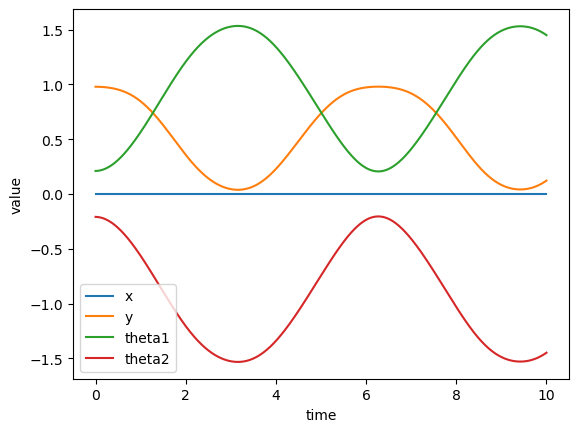

In [6]:
lambda_dict = lambdify_sys([*q,*q_dot , t] , system_solution , q_ddot)

system_equation = make_system_equation(lambda_dict,q_ddot)
q_init = [0,L*np.cos(np.pi/15) , np.pi/15 , -np.pi/15 ,0,0,0,0]
t_range = [0,10]
dt = 0.01
tvec , traj = simulate( system_equation , q_init,t_range,dt,integrate)


plt.figure(1)
plt.plot(tvec , traj[0] , label = "x")
plt.plot(tvec , traj[1] , label = "y")
plt.plot(tvec , traj[2] , label = "theta1")
plt.plot(tvec , traj[3] , label = "theta2")
plt.xlabel("time")
plt.ylabel("value")
plt.legend()
plt.plot()

[]

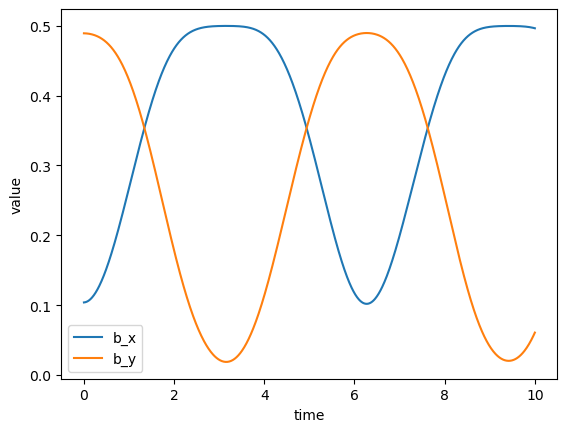

In [7]:
# This is to proof the lambda the transformation works

sym_trans_dict = { "Twa": Twa , "Twb":Twb , "Twc":Twc}


trans_lambdas = lambdify_sys([*q,*q_dot] , sym_trans_dict )


plt.figure(1)
b_x = []
b_y = []
for one_state in traj.T:
    Twb_val = trans_lambdas["Twb"](*one_state)
    x,y = get_x_y(Twb_val)
    b_x.append(x)
    b_y.append(y)
    
plt.plot(tvec , b_x , label = "b_x")
plt.plot(tvec , b_y , label = "b_y")
plt.xlabel("time")
plt.ylabel("value")
plt.legend()
plt.plot()


In [9]:
def animate_foot(state_array,L=1,W=0.2,T=10):
    """
    Function to generate web-based animation of double-pendulum system

    Parameters:
    ================================================
    theta_array:
        trajectory of x y t1 t2, should be a NumPy array with
        shape of (4,N)
    L:
        length of leg
    W:
        width of leg
    T:
        length/seconds of animation duration

    Returns: None
    """

    ################################
    # Imports required for animation.
    from plotly.offline import init_notebook_mode, iplot
    import plotly.graph_objects as go
    ####################################
    # Using these to specify axis limits.
    xm = -2 #np.min(xx1)-0.5
    xM = 2 #np.max(xx1)+0.5
    ym = -1 #np.min(yy1)-2.5
    yM = 2 #np.max(yy1)+1.5

    layout=dict(autosize=False, width=1000, height=1000,
                xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Biped Simulation',
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                                'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                            {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                            ]
                                }]
                )


    # N = len(state_array[0]) # Need this for specifying length of simulation
    def gen_transform_frame_axis_datas(T , frame_size = 0.15 , name=None):
        frame_x , frame_y = get_x_y(T)
        px = np.array([frame_size,0,0,1])
        py = np.array([0,frame_size,0,1])
        x_tip = T@px.T
        y_tip = T@py.T
        return [
            go.Scatter(name=name,
                       x=[frame_x, x_tip[0]],
                       y=[frame_y, x_tip[1]],
                       mode='lines',
                       line=dict(color='green', width=3)),
            go.Scatter(name=name,
                       x=[frame_x, y_tip[0]],
                       y=[frame_y, y_tip[1]],
                       mode='lines',
                       line=dict(color='red', width=3))
        ]

    def gen_lines_offset_from_transform(T,start_end_pairs:list[tuple[tuple[float,float],tuple[float,float]]]):
        output = []
        for s , e  in start_end_pairs:
            p_start = T@np.array([s[0] , s[1] , 0 , 1]).T
            p_end = T@np.array([e[0] , e[1] , 0 , 1]).T
            output.append(
                go.Scatter(x=[p_start[0], p_end[0]],
                           y=[p_start[1], p_end[1]],
                           mode='lines',
                           line=dict(color='green', width=2)))
        return output

    def gen_rect_from_transform(T,L,W , color='green' , name=None):
        corners = [
            np.array([-W/2 , L/2 , 0 , 1]),
            np.array([-W/2 , -L/2 , 0 , 1]),
            np.array([W/2 , -L/2 , 0 , 1]),
            np.array([W/2 , L/2 , 0 , 1]),
        ]
        poses = []
        for c in corners:
            c_pos = T@c.T
            poses.append(c_pos)
        last_pos = poses[-1]
        output = []
        for p in poses:
            output.append(
                go.Scatter(name=name,
                           x=[last_pos[0], p[0]],
                           y=[last_pos[1], p[1]],
                           mode='lines',
                           line=dict(color=color, width=2)))
            last_pos = p
        return output

    frames=[]
    for state in state_array.T:
        frame_datas = []

        Twa_num = trans_lambdas["Twa"](*state)
        Twb_num = trans_lambdas["Twb"](*state)
        Twc_num = trans_lambdas["Twc"](*state)
        # b_x,b_y = get_x_y(Twb_num)
        # c_x,c_y = get_x_y(Twc_num)
        frame_datas.append(
            go.Scatter(x=[-3,3],
                y=[0,0],
                mode='lines',
                line=dict(color='green', width=3)
                ,name="Ground"
                ),
        )
        
        frame_datas.extend(gen_transform_frame_axis_datas(Twa_num,name="Twa_frame"))
        frame_datas.extend(gen_transform_frame_axis_datas(Twb_num , name="Twb_frame"))
        frame_datas.extend(gen_transform_frame_axis_datas(Twc_num,name="Twc_frame"))
        frame_datas.extend(gen_rect_from_transform(Twb_num,L,W,color="blue" , name="leg 1"))
        frame_datas.extend(gen_rect_from_transform(Twc_num,L,W,color="purple",name="leg 2"))
        # Generate the frame object and save it.
        frames.append(go.Frame(data=frame_datas))


    figure1=go.Figure(data=frames[0].data, layout=layout, frames=frames)
    iplot(figure1)

animate_foot(traj)


## Collaboration list

* Srikanth Schelbert
* Jingkun Liu
* Shail Dalal
* Shail Dalal

